# Evaluate the Effect of Training 
We can assess whether retraining Difflinker leads to improved performance in two ways:
1. Evaluate how much the success rate improves with re-training
2. The difference between the total number of stable MOFs found w/ and w/o a closed loop

In [1]:
from matplotlib import pyplot as plt
from itertools import chain
from scipy.interpolate import interp1d
from pathlib import Path
import pandas as pd

Config

In [2]:
summary_paths = list(chain(Path('summaries').glob('*-nodes.csv.gz'), Path('summaries').glob('*-nodes_repeat-*.csv.gz'), Path('summaries').glob('*no-retrain*.csv.gz')))

## Route 1: Measure Success Rate by Model Generation
Measure the success rate of models as a function of generation

In [3]:
success_data = []
for path in summary_paths:
    # Get metadata
    count = int(path.name.split("-")[0])
    retrain = 'no-retrain' not in path.name

    # Pull the success rate
    mofs = pd.read_csv(path)
    mofs['stable'] = mofs['structure_stability.uff'] < 0.1

    for gen, subset in mofs.groupby('model_version'):
        success_data.append({
            'name': path.name,
            'nodes': count,
            'first': subset['walltime'].min(),
            'retrain': retrain,
            'version': gen,
            'total': len(subset),
            'stable': subset['stable'].sum(),
            'stable_frac': subset['stable'].mean()
        })
success_data = pd.DataFrame(success_data)

Look at a coarse metric: the success rate by generation for one of the larger runs. I pick a larger run because I get more MOFs per generation of model and therefore better assessments of success rate.

Text(0, 0.5, 'Success Rate')

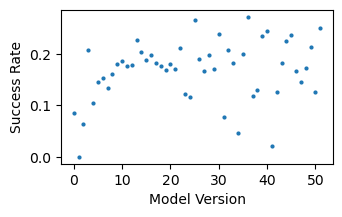

In [4]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

for count, subset in success_data.query('nodes==256').groupby('nodes'):
    ax.scatter(subset['version'], subset['stable_frac'], s=4)

ax.set_xlabel('Model Version')
ax.set_ylabel('Success Rate')

Now, narrow down: does using the original (version 0) model the whole time have a success rate.

In [5]:
success_data.query('nodes == 64 and not retrain')

,name,nodes,first,retrain,version,total,stable,stable_frac
350,64-nodes_no-retrain_repeat-2.csv.gz,64,0.0,False,0,9770,807,0.082600
352,64-nodes_no-retrain.csv.gz,64,0.0,False,0,9894,723,0.073075


In [6]:
success_data.query('nodes == 64 and retrain and version > 30').groupby('name').mean()

,nodes,first,retrain,version,total,stable,stable_frac
name,,,,,,,
64-nodes_repeat-1.csv.gz,64.0,6181.947368,1.0,40.0,355.210526,55.684211,0.156088


*Finding*: Yes, by about a factor of two

### Success Rate Over Time
See the success rate for the model at specific versions

In [7]:
version_range = (10, 15)
version_query = f'{version_range[0]} <= version < {version_range[1]}'

In [8]:
subset = success_data.query(f'nodes == 64 and retrain and ({version_query})')
subset['stable'].sum() / subset['total'].sum()

0.07627118644067797

In [9]:
subset = success_data.query(f'nodes == 450 and retrain and ({version_query})')
subset['stable'].sum() / subset['total'].sum()

0.20435499381783212

In [10]:
train_times = []
for path in summary_paths:
    run_name = path.name[:-7]
    train_path = Path('../prod-runs/') / run_name / 'training-results.json'
    if not train_path.exists():
        continue
    gen_results = pd.read_json(train_path, lines=True)

    if len(gen_results) <= max(version_range):
        continue

    start_time = pd.read_json(train_path.with_name('generation-results.json'), lines=True)['timestamp'].apply(lambda x: x['created']).min()
    train_times.append({
        'run_name': run_name,
        'first_model': gen_results.loc[version_range[0]]['timestamp']['result_received'] - start_time,
        'last_model': gen_results.loc[version_range[1]]['timestamp']['result_received'] - start_time
    })
pd.DataFrame(train_times)

,run_name,first_model,last_model
0,450-nodes,3929.074964,5641.283397
1,256-nodes,2938.491185,5062.843928
2,128-nodes,1719.499924,2980.585390
3,32-nodes_repeat-2,1061.783903,1206.604001
4,64-nodes_repeat-1,1227.653536,1560.948423
5,32-nodes_repeat-1,1465.578338,1672.156181


## Round 2: Assess workflow outcomes w/o retraining
Show that it gets better

### Get the "Stable Found" at 90 minutes
Loop over all runs and store: scale, if retrained or not, and the number of stable found after 90 minutes. 
The 450-node run switches how it trained DiffLinker at around 90 minutes, and we don't want to study that effect yet.

In [11]:
hours = 1.5

In [12]:
mofs['stable'] = mofs['structure_stability.uff'] < 0.1

In [13]:
success_data = []
for path in summary_paths:
    # Get metadata
    count = int(path.name.split("-")[0])
    retrain = 'no-retrain' not in path.name

    # Pull the success rate
    mofs = pd.read_csv(path)
    num_found = interp1d(mofs['walltime'], mofs['cumulative_found'], kind='previous')(hours * 3600).item()
    num_evald = interp1d(mofs['walltime'], mofs.index, kind='previous')(hours * 3600).item()

    success_data.append({
        'nodes': count,
        'retrain': retrain,
        'found': num_found,
        'found_node-hr': num_found / (count * hours),
        'success_rate': num_found / num_evald
    })
success_data = pd.DataFrame(success_data)

In [14]:
success_data.groupby(['nodes', 'retrain']).mean()

found  found_node-hr  success_rate
nodes retrain                                     
32    False     133.0       2.770833      0.048576
      True      313.0       6.520833      0.107990
64    False     426.5       4.442708      0.079204
      True      641.0       6.677083      0.118748
128   True     1622.0       8.447917      0.151010
256   True     3633.0       9.460938      0.167969
450   True     6554.0       9.709630      0.173166